# Building a model to predict just Machine Failure

This notebook plays some techniques to improve performance in predicting Machine Failure, specifically with a crude sampling to balance the training dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.discriminant_analysis import StandardScaler
from scipy.stats import hmean

from pyprojroot import here
import wandb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Download the latest data
if False:
    run = wandb.init()
    artifact = run.use_artifact('w207-predictive-maintenance/predictive-maintenance/ai4i2020:v0', type='dataset')
    artifact_dir = artifact.download(here('data'))

In [3]:
X_train = pd.read_csv(here('data/processed/X_train.csv'))
print(f"X_train {X_train.shape}:")
print(X_train.describe())
print()
Y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(f"Y_train {Y_train.shape}:")
print(Y_train.describe())

X_val = pd.read_csv(here('data/processed/X_val.csv'))
print(f"X_val {X_val.shape}:")
print(X_val.describe())
print()
Y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(f"Y_val {Y_val.shape}:")
print(Y_val.describe())

X_train (7499, 6):
       quality_variation  Air temperature  Process temperature  \
count        7499.000000      7499.000000          7499.000000   
mean            0.498066       300.002854           310.005347   
std             0.669290         2.005323             1.484268   
min             0.000000       295.300000           305.700000   
25%             0.000000       298.300000           308.800000   
50%             0.000000       300.100000           310.100000   
75%             1.000000       301.500000           311.100000   
max             2.000000       304.500000           313.800000   

       Rotational speed       Torque    Tool wear  
count       7499.000000  7499.000000  7499.000000  
mean        1537.916789    40.039725   108.030004  
std          180.646539     9.970724    63.685869  
min         1181.000000     3.800000     0.000000  
25%         1422.000000    33.300000    53.000000  
50%         1502.000000    40.100000   108.000000  
75%         1610.00000

In [4]:
# standardize
sc_x = StandardScaler()

X_train_std = pd.DataFrame(sc_x.fit(X_train).transform(X_train), columns=X_train.columns)
X_val_std = pd.DataFrame(sc_x.fit(X_train).transform(X_val), columns=X_val.columns)
# X_test_std = sc_x.fit(X_train).transform(X_test)

In [45]:
# Downsample to have equal positive and negative examples in train, and in a random order
np.random.seed(88)

positive_examples = Y_train.index[Y_train["Machine failure"] == 1].to_numpy()
negative_examples = Y_train.index[Y_train["Machine failure"] == 0].to_numpy()

selected_positive_examples = np.random.choice(positive_examples, 
                                              size=negative_examples.shape[0],
                                              replace=True)
selected_negative_examples = negative_examples

selected_examples = np.concatenate((selected_positive_examples, selected_negative_examples))
np.random.shuffle(selected_examples)

print(f"Selected examples {selected_examples}")

X_train_downsampled = X_train_std.values[selected_examples]
Y_train_downsampled = Y_train.values[selected_examples]

print(f"X_train_downsampled {X_train_downsampled.shape}")
print(X_train_downsampled)
print(f"Y_train_downsampled {Y_train_downsampled.shape}")
print(Y_train_downsampled)

Selected examples [1524 2507 1956 ... 5877 1172 4292]
X_train_downsampled (14508, 6)
[[-0.74422097 -0.50012921  0.13115261 -0.58635971  0.21667621 -0.33023662]
 [-0.74422097  1.44482436  1.61346376 -0.85762573  1.13943902  0.81609096]
 [ 0.74999939 -0.84922344 -1.48591409 -0.29294952  0.19661615 -1.49226732]
 ...
 [-0.74422097 -2.14585915 -2.56395857  4.05284282 -2.5516122   0.64335666]
 [-0.74422097 -1.79676492 -1.75542521  7.16963401 -3.45431495  1.64835619]
 [-0.74422097  1.09573013  0.40066373 -1.12889174  1.31997956  0.80038784]]
Y_train_downsampled (14508, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 1 0 0 0]]


In [54]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.Input(
    shape=[X_train.shape[1]],
    name="Input"
))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(
    units=1,
    use_bias=True,
    activation=None
))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=optimizer,
              metrics=["accuracy","precision", "recall"]
              )

In [55]:
history = model.fit(
          x=X_train_downsampled, y=Y_train_downsampled[:,0],
          validation_data=[X_val_std, Y_val.values[:,0]],
          epochs=2000,
          verbose=1
)

Epoch 1/2000


454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.7528 - loss: 0.7234 - precision: 0.8794 - recall: 0.5859 - val_accuracy: 0.9167 - val_loss: 0.4546 - val_precision: 0.2699 - val_recall: 0.8800
Epoch 2/2000
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.8577 - loss: 0.4392 - precision: 0.8899 - recall: 0.8164 - val_accuracy: 0.9167 - val_loss: 0.3901 - val_precision: 0.2727 - val_recall: 0.9000
Epoch 3/2000
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.8700 - loss: 0.3954 - precision: 0.8953 - recall: 0.8380 - val_accuracy: 0.9241 - val_loss: 0.3550 - val_precision: 0.2922 - val_recall: 0.9000
Epoch 4/2000
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.8731 - loss: 0.3796 - precision: 0.8989 - recall: 0.8408 - val_accuracy: 0.9320 - val_loss: 0.3241 - val_precision: 0.3194 - val_recall: 0.9200
Epoch 5/2000
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.8828 - loss: 0.3621 - precision: 0.9041 - recall: 0.8565 - val_accuracy: 0.9241 - val_l

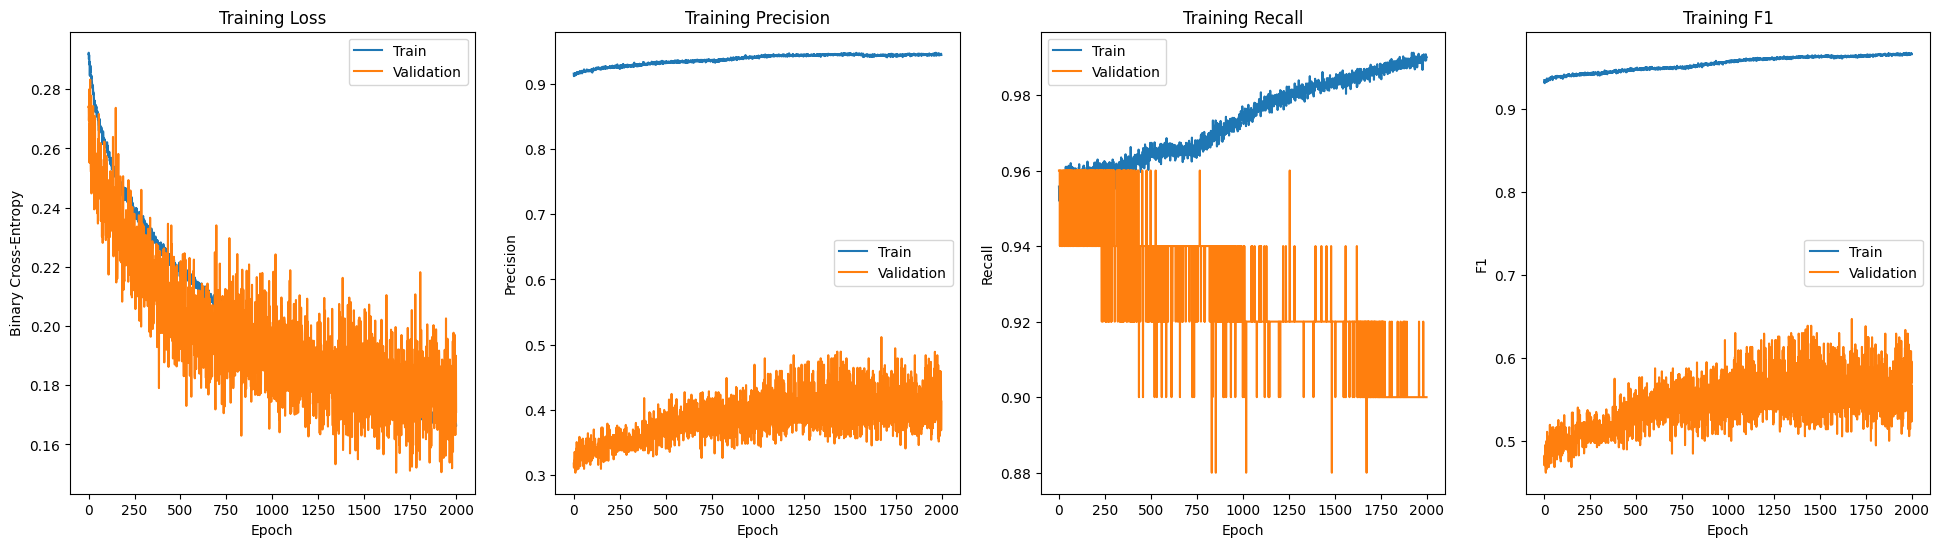

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,6))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary Cross-Entropy")
axes[0].legend(["Train", "Validation"])

axes[1].plot(history.history['precision'])
axes[1].plot(history.history['val_precision'])
axes[1].set_title("Training Precision")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Precision")
axes[1].legend(["Train", "Validation"])

axes[2].plot(history.history['recall'])
axes[2].plot(history.history['val_recall'])
axes[2].set_title("Training Recall")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Recall")
axes[2].legend(["Train", "Validation"])

axes[3].plot(hmean(np.stack((history.history["precision"], history.history["recall"]), axis=0)))
axes[3].plot(hmean(np.stack((history.history["val_precision"], history.history["val_recall"]), axis=0)))
axes[3].set_title("Training F1")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("F1")
axes[3].legend(["Train", "Validation"])